In [3]:
!pip install py4j

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
from pyspark import SparkConf, SparkContext, SQLContext

In [5]:
# Configure spark context settings and initialize SQL context
conf = (SparkConf()
         .setAppName("s3a_test")
         .set("spark.executor.instances", "8")
         .set("spark.executor.cores", 2)
         .set("spark.shuffle.compress", "true")
         .set("spark.io.compression.codec", "snappy")
         .set("spark.executor.memory", "2g"))

sc = SparkContext(conf = conf)

sqlContext = SQLContext(sc)

## Load Data, Manage Format for Regression

In [6]:
# READ DATA FILE
df = sqlContext.read.load("training.json")

In [7]:
df.printSchema()

root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)



In [8]:
df.count()

4230796

In [9]:
# Work on random sample of the data
data = df.sample(False, 0.01, seed=None)

In [10]:
data.count()

42337

## Split Training and Testing

In [ ]:
training, testing = data.randomSplit([0.7, 0.3])

In [ ]:
import numpy as np

# Convert to numpy array
X_train = np.array(training.select('features').collect()).squeeze()
y_train = np.array(training.select('label').collect()).squeeze()
X_test = np.array(testing.select('features').collect()).squeeze()
y_test = np.array(testing.select('label').collect()).squeeze()

# Drop last column from X_train and X_test - this column accidentally contains the label
X_train = X_train[:,0:-1]
X_test = X_test[:,0:-1]

## Multinomial Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression

# Initialize Model
lr = LogisticRegression()

# Fit training data
model = lr.fit(X_train, y_train)

# Predict labels on test data
preds = model.predict(X_test)

In [13]:
import matplotlib.pyplot as plt
plt.hist(preds)
plt.plot()

NameError: name 'preds' is not defined

In [ ]:
from sklearn.model_selection import GridSearchCV
lr_params = {'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']} #, 'penalty':['l1','l2']}
lr = LogisticRegression()
clf = GridSearchCV(lr, lr_params)

In [ ]:
clf.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:414: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:414: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not 

In [ ]:
clf.cv_results_.keys()

In [ ]:
clf.cv_results_['rank_test_score']

In [ ]:
lr_params

## Random Forest

In [11]:
from sklearn import tree

decTree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
model = decTree.fit(X_train, y_train)
pred = model.predict(X_test)

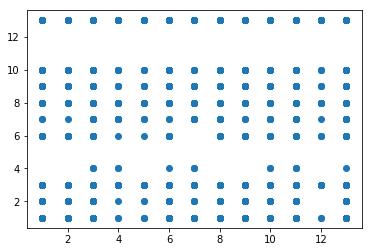

In [15]:
plt.scatter(y_test,pred)

In [16]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(n_estimators=100, verbose=1)

model = RFC.fit(X_train, y_train)

pred = model.predict(X_test)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   19.7s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished


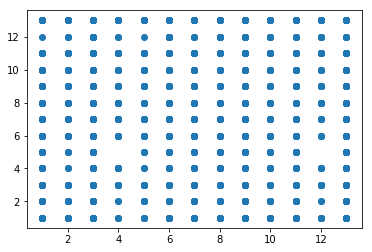

In [17]:
plt.scatter(y_test, pred)

In [18]:
num_correct = np.sum(y_test == pred)

In [19]:
accuracy = num_correct / X_test.shape[0]
print(accuracy)

0.21026477211


In [22]:
# Exhaustive Hyperparameter Search
from sklearn.model_selection import GridSearchCV
rfc_params = {'n_estimators':[10, 25, 50, 100], 'min_samples_split':[20, 50, 75, 100, 150]}
rfc = RandomForestClassifier()
rfc_search = GridSearchCV(rfc, rfc_params)

In [23]:
rfc_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 25, 50, 100], 'min_samples_split': [20, 50, 75, 100, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [24]:
rfc_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_min_samples_split', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])

In [25]:
rfc_search.cv_results_['params']

[{'min_samples_split': 20, 'n_estimators': 10},
 {'min_samples_split': 20, 'n_estimators': 25},
 {'min_samples_split': 20, 'n_estimators': 50},
 {'min_samples_split': 20, 'n_estimators': 100},
 {'min_samples_split': 50, 'n_estimators': 10},
 {'min_samples_split': 50, 'n_estimators': 25},
 {'min_samples_split': 50, 'n_estimators': 50},
 {'min_samples_split': 50, 'n_estimators': 100},
 {'min_samples_split': 75, 'n_estimators': 10},
 {'min_samples_split': 75, 'n_estimators': 25},
 {'min_samples_split': 75, 'n_estimators': 50},
 {'min_samples_split': 75, 'n_estimators': 100},
 {'min_samples_split': 100, 'n_estimators': 10},
 {'min_samples_split': 100, 'n_estimators': 25},
 {'min_samples_split': 100, 'n_estimators': 50},
 {'min_samples_split': 100, 'n_estimators': 100},
 {'min_samples_split': 150, 'n_estimators': 10},
 {'min_samples_split': 150, 'n_estimators': 25},
 {'min_samples_split': 150, 'n_estimators': 50},
 {'min_samples_split': 150, 'n_estimators': 100}]

In [26]:
rfc_search.cv_results_['mean_fit_time']

array([ 1.36606574,  2.24221746,  2.79455368,  5.80007164,  0.69985167,
        1.3325843 ,  2.62081265,  4.89796726,  0.65678366,  1.35125605,
        2.37352967,  4.60840408,  0.68111277,  1.43312955,  2.36282365,
        4.66839568,  0.63643829,  1.19005791,  2.31698298,  4.44582518])

In [27]:
rfc_search.cv_results_['mean_score_time']

array([ 0.05324324,  0.11145306,  0.19063918,  0.39302198,  0.03912369,
        0.08426746,  0.16532993,  0.32916975,  0.04394992,  0.08451064,
        0.15967226,  0.31294632,  0.04469919,  0.08899983,  0.1580929 ,
        0.31789835,  0.0365204 ,  0.07972924,  0.14627536,  0.29177467])

In [37]:
rfc_search_train = rfc_search.cv_results_['mean_train_score']

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [48]:
rfc_search_test = rfc_search.cv_results_['mean_test_score']

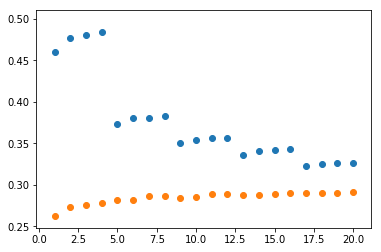

In [49]:
plt.scatter(np.array(range(1,len(rfc_search_train)+1)),rfc_search_train)
plt.scatter(np.array(range(1,len(rfc_search_test)+1)),rfc_search_test)

<Container object of 20 artists>

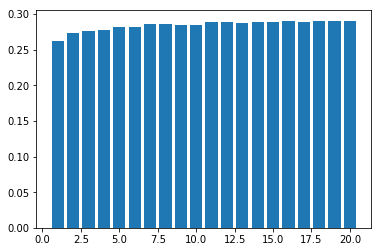

In [29]:
plt.bar(np.array(range(1,len(rfc_search.cv_results_['params'])+1)),rfc_search.cv_results_['mean_test_score'])

In [30]:
len(rfc_search.cv_results_['params'])

20

## Boosting

In [50]:
from sklearn.ensemble import AdaBoostClassifier

adaBoost = AdaBoostClassifier(n_estimators=20)

model = adaBoost.fit(X_train, y_train)

pred = adaBoost.predict(X_test)

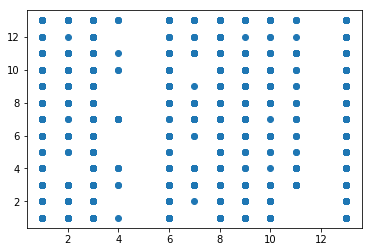

In [51]:
plt.scatter(pred, y_test)

In [52]:
accuracy = sum(pred == y_test)/y_test.shape[0]
print(accuracy)

0.282552993245


In [53]:
# Hyperparameter Search
adaB_params = {'n_estimators':[20, 30, 40, 50, 60, 70, 80, 90, 100], 'learning_rate':[0.1, 0.5, 1.0, 1.5, 2.0]}
adaB_class = AdaBoostClassifier()
adaB_search = GridSearchCV(adaB_class, adaB_params)
adaB_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [20, 30, 40, 50, 60, 70, 80, 90, 100], 'learning_rate': [0.1, 0.5, 1.0, 1.5, 2.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [54]:
adaB_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_learning_rate', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])

In [55]:
adaB_search.cv_results_['params']

[{'learning_rate': 0.1, 'n_estimators': 20},
 {'learning_rate': 0.1, 'n_estimators': 30},
 {'learning_rate': 0.1, 'n_estimators': 40},
 {'learning_rate': 0.1, 'n_estimators': 50},
 {'learning_rate': 0.1, 'n_estimators': 60},
 {'learning_rate': 0.1, 'n_estimators': 70},
 {'learning_rate': 0.1, 'n_estimators': 80},
 {'learning_rate': 0.1, 'n_estimators': 90},
 {'learning_rate': 0.1, 'n_estimators': 100},
 {'learning_rate': 0.5, 'n_estimators': 20},
 {'learning_rate': 0.5, 'n_estimators': 30},
 {'learning_rate': 0.5, 'n_estimators': 40},
 {'learning_rate': 0.5, 'n_estimators': 50},
 {'learning_rate': 0.5, 'n_estimators': 60},
 {'learning_rate': 0.5, 'n_estimators': 70},
 {'learning_rate': 0.5, 'n_estimators': 80},
 {'learning_rate': 0.5, 'n_estimators': 90},
 {'learning_rate': 0.5, 'n_estimators': 100},
 {'learning_rate': 1.0, 'n_estimators': 20},
 {'learning_rate': 1.0, 'n_estimators': 30},
 {'learning_rate': 1.0, 'n_estimators': 40},
 {'learning_rate': 1.0, 'n_estimators': 50},
 {'learn

In [1]:
adaB_search.cv_results_['mean_test_score']

NameError: name 'adaB_search' is not defined

In [2]:
adaB_search.cv_results_['mean_test_score']

NameError: name 'adaB_search' is not defined

In [ ]:
plt.scatter(np.array(range(1,len(rfc_search_train)+1)),rfc_search_train)
# plt.legend("Training Accuracy", fontsize=12)
plt.scatter(np.array(range(1,len(rfc_search_test)+1)),rfc_search_test)
# plt.legend("Testing Accuracy", fontsize=12)

## Multilayer Perceptron

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

mlpc = MLPClassifier()
model = mlpc.fit(X_train, y_train)
pred = model.predict(X_test)

In [ ]:
# Accuracy
np.sum(pred == y_test) / pred.shape[0]